## DecisionTreeRegressor

В [decisiontree.py](decisiontree.py) я создал класс `DecisionTreeRegressor`,
в котором реализовал алгоритм машинного обучения "решающее дерево"\
Для примера решил задачу регрессии "Предсказание количества дней просрочки при выдаче кредита".\
Целевая переменная — количество дней просрочки по кредиту `delay_days`. \
Результат я сравниваю с `sklearn DecisionTreeRegressor`.

In [23]:
import json
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor, plot_tree

import decisiontree

Загрузим датасет и разделим данные на тренировочные и тестовые.

In [2]:
df = pd.read_csv('loan_delay_days.csv')


In [3]:
X=df.drop('delay_days', axis=1)
y=np.array(df[['delay_days']])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Построение дерева

Дерево строится рекурсивно (depth-wise):

- корневой узел делится на два дочерних,
- каждая дочерняя нода делится независимо,
- процесс продолжается, пока не выполнится критерий остановки.

В качестве критериев остановки используются:
- `max_depth` — максимальная глубина дерева,
- `min_samples_split` — минимальное число объектов в узле.


In [5]:
tree_manual = decisiontree.DecisionTreeRegressor(max_depth=3, min_samples_split=2)

In [6]:
tree_manual.fit(X_train.values, y_train)

DecisionTreeRegressor(max_depth=3, min_samples_split=2)

### Предсказание в листе

В листовых узлах дерева хранится среднее значение таргета
по объектам, попавшим в данный узел.

Во время предсказания дерево обходится сверху вниз,
а значение в листе возвращается как предсказание.


In [7]:
y_pred_manual = tree_manual.predict(X_test.values)

### Структура дерева

Ниже показана структура построенного дерева в формате JSON.
Вывод используется как инструмент отладки и позволяет убедиться,
что дерево действительно строится рекурсивно и содержит разбиения
по признакам и порогам.


In [27]:
tree_dict = json.loads(tree_manual.as_json())
pprint(tree_dict)

{'feature': 1,
 'left': {'feature': 8,
          'left': {'feature': 9,
                   'left': {'mse': 88.69,
                            'n_samples': 134,
                            'value': 11.007462686567164},
                   'mse': 262.31,
                   'n_samples': 246,
                   'right': {'mse': 232.64,
                             'n_samples': 112,
                             'value': 31.883928571428573},
                   'threshold': 960.0},
          'mse': 613.3,
          'n_samples': 318,
          'right': {'feature': 9,
                    'left': {'mse': 235.21,
                             'n_samples': 27,
                             'value': 28.555555555555557},
                    'mse': 889.41,
                    'n_samples': 72,
                    'right': {'mse': 607.78,
                              'n_samples': 45,
                              'value': 70.95555555555555},
                    'threshold': 720.0},
          'threshold':

### Критерий качества сплита

Для оценки качества разбиений используется среднеквадратичная ошибка (MSE).

В регрессионном дереве предсказанием узла является среднее значение таргета,
поэтому минимизация MSE эквивалентна минимизации дисперсии
целевой переменной внутри узлов.


In [9]:
mse_manual = mean_squared_error(y_test, y_pred_manual)

In [10]:
mse_manual

117.53001955850551

### Предсказания vs истинные значения

На графике ниже показано сравнение истинных значений целевой переменной
(количество дней просрочки) и предсказаний модели на тестовой выборке.

Пунктирная линия соответствует идеальному предсказанию `y = x`.
Чем ближе точки к этой линии, тем точнее предсказания модели.

Для деревьев решений характерна ступенчатая структура предсказаний,
так как в каждом листе хранится одно среднее значение.


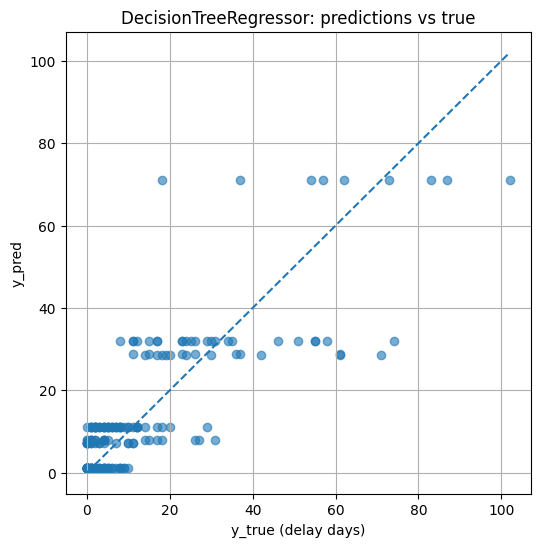

In [41]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_manual, alpha=0.6)

# линия идеального предсказания
lims = [
    min(y_test.min(), y_pred_manual.min()),
    max(y_test.max(), y_pred_manual.max())
]
plt.plot(lims, lims, linestyle="--")

plt.xlabel("y_true (delay days)")
plt.ylabel("y_pred")
plt.title("DecisionTreeRegressor: predictions vs true")
plt.grid(True)
plt.show()

### Распределение ошибок (residuals)

На графике показано распределение ошибок предсказания,
где ошибка определяется как разность между истинным значением
и предсказанием модели:\
`error = y_true - y_pred`.

Анализ распределения ошибок позволяет оценить:
- наличие смещения модели,
- симметричность ошибок,
- наличие длинных хвостов и выбросов.

__Для задачи прогнозирования дней просрочки наличие асимметричного распределения
ошибок может указывать на редкие, но существенные случаи большой задержки платежей.__



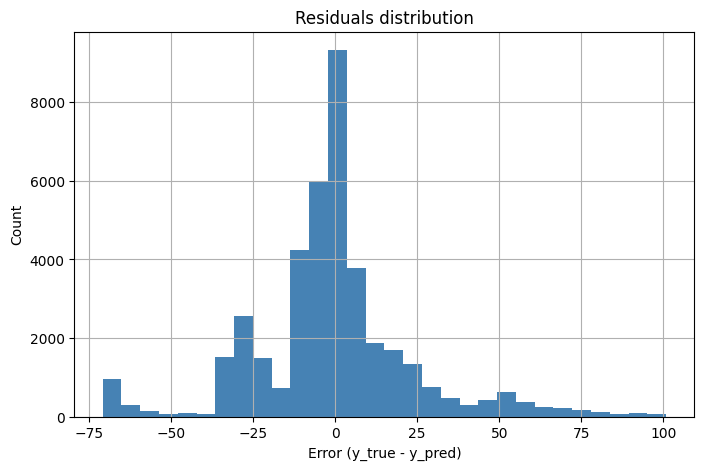

In [40]:
errors = (y_test - y_pred_manual).ravel()

plt.figure(figsize=(8, 5))
plt.hist(errors, bins=30, color='steelblue')
plt.xlabel("Error (y_true - y_pred)")
plt.ylabel("Count")
plt.title("Residuals distribution")
plt.grid(True)
plt.show()

### Сравнение со sklearn

Поскольку модель реализует тот же принцип,
что и `DecisionTreeRegressor` из `sklearn`
(регрессия + MSE + среднее значение в листе),
результаты можно корректно сравнивать по метрикам
MAE и MSE на одинаковом train/test разбиении.


In [11]:
# Создадим дерево с такими же параметрами 
tree_sklearn = DecisionTreeRegressor(max_depth=3, min_samples_split=2, random_state=42, criterion='squared_error')
tree_sklearn.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [12]:
y_pred_sklearn = tree_sklearn.predict(X_test)

In [13]:
# Расчитаем MSE
mse_sklearn = mean_squared_error(y_test, y_pred_sklearn)

In [14]:
print(f'MSE ручного расчета: {mse_manual}\n'
      f'MSE расчета в sklearn: {mse_sklearn}')

MSE ручного расчета: 117.53001955850551
MSE расчета в sklearn: 117.53001955850551


## Анализ результатов

Визуализации подтверждают, что модель улавливает общую зависимость
между признаками и целевой переменной, однако предсказания имеют
ступенчатый характер, типичный для деревьев решений.

Распределение ошибок показывает, что часть объектов имеет
существенные отклонения, что может быть связано с выбросами
или недостаточной глубиной дерева.

Для улучшения качества модели возможны:
- увеличение `max_depth`,
- использование ансамблевых методов (Random Forest, Gradient Boosting),
- дополнительная обработка признаков.
